# Tarea 2
## b)


In [46]:
import random
import matplotlib.pyplot as plt
import simpy
import networkx as nx  
import numpy as np
from scipy.stats import poisson
from Norta import Norta as Nt

Primero tenemos la clase que define las actividades, utilizando métodos de simpy

In [ ]:
class ActivityProcess(object):
    def __init__(self, env, name, observation = []):
        self.env = env
        self.name = name
        self.distribution = observation
        
    def waitup(self, node, myEvent):
        # PEM illustrating "waitevent"# wait for "myEvent" to occur
        evnt = [e.event for e in myEvent]
        yield self.env.all_of(evnt)
        print("The activating event(s) were %s at time %f" %([x.name for x in myEvent], self.env.now))
        tis = self.generate_observation()
        yield self.env.timeout(tis)
        finishtime = self.env.now
        if finishtime > SANglobal.finishtime:
            SANglobal.finishtime = finishtime
        SANglobal.F.nodecomplete[node].event.succeed()
    
    def generate_observation(self):
        if observation != []:
            return observation
        else:
            return random.expovariate(1.0)

Clase para iniciar las señales

In [3]:
class StartSignaller(object):
    # here we just schedule some events to fire
    def __init__(self, env, name,sEvent):
        self.env = env
        self.name = name
        self.sEvent = sEvent
        self.env.process(self.startSignals())
        
    def startSignals(self):
        yield self.env.timeout(0)
        self.sEvent.event.succeed()

Y la clase que define el evento

In [4]:
class CustomEvent(object):
    def __init__(self,env, name):
        self.name = name
        self.env = env
        self.event = self.env.event()        

Y aca llamamos a Norta, que generará una observación para las actividades necesarias:

In [39]:
class Norta(object):
    def __init__(self):
        self.env = Nt()
    
    def set_marginal(self,distribution,params):
        self.env.set_marginal(distribution, mu=15, sigma=1)
    
    def set_correlation_matrix(self,R):
        self.env.set_corr_matrix(R)
    
    def generate_sample(self,m=1):
        return self.env.generate_sample(1)

Ahora tenemos la clase que contiene los elementos a analiza y guardar a la vez en networkx como grafo

In [37]:
class SANglobal:
    F = nx.DiGraph()
    a = 0
    b = 1
    c = 2
    d = 3
    inTo = 0
    F.add_nodes_from([a, b, c, d])
    F.add_edges_from([(a,b), (a,c), (b,c), (b,d), (c,d)])
    finishtime = 0
    correlated = [{'vertice':(b,c),'corr':0.5}]
    distribution = {b:{'func':'poisson','params': {'mu':1.0}}, #solo las distribuciones de las que estan correlacionadas
                   c:{'func':'poisson','params': {'mu':1.0}}}

In [47]:
Gen = Norta()
for correlations in SANglobal.correlated:
    for vertice in correlations['vertice']:
        Gen.set_marginal(SANglobal.distribution[vertice]['func'],SANglobal.distribution[vertice]['params'])
    R = [[1, correlations['corr']],[correlations['corr'], 1]] # sólo efectivo para 2 dimensiones
    Gen.set_correlation_matrix(R)
muestra = Gen.generate_sample() #va a tener dos dimensiones la primera de b, la segunda de c
print(muestra)

Poisson function successfully added
Poisson function successfully added
0.5
Calculated correlataion:
 [[1.  0.5]
 [0.5 1. ]]
[[15. 14.]]


Podemos hechar un vistazo

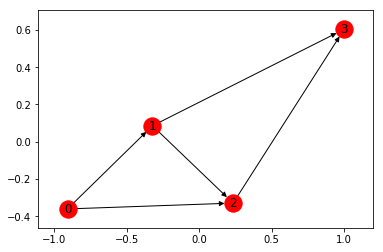

In [16]:
nx.draw_networkx(SANglobal.F)
plt.show()

In [22]:
    R = [[1, corr],[corr, 1]]
    Prueba.set_marginal('poisson', mu=1)
    Prueba.set_marginal('poisson', mu=2)
    sample_data = Prueba.generate_sample(1)

#for i in range(len(SANglobal.F.nodes())):
#    eventname = 'Complete %1d' % i
#    SANglobal.F.nodecomplete.append(CustomEvent(env,eventname))
if SANglobal.function['a']['params']:
    print("yes")

yes


The activating event(s) were ['Start']
The activating event(s) were ['Complete0']
The activating event(s) were ['Complete0', 'Complete1']
The activating event(s) were ['Complete1', 'Complete2']
The activating event(s) were ['Start']
The activating event(s) were ['Complete0']
The activating event(s) were ['Complete0', 'Complete1']
The activating event(s) were ['Complete1', 'Complete2']


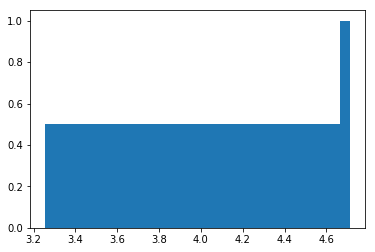

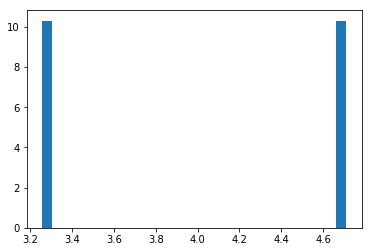

In [8]:
finishtimes = [] #el contenedor de los tiempos de término
for rep in range(2):
    SANglobal.finishtime = 0 #El tiempo de termino es inicializado
    env = simpy.Environment() #El ambiente es activado
    
    SANglobal.F.nodecomplete= [] #Las actividades que se van completando quedan aca
    for i in range(len(SANglobal.F.nodes())):
        eventname = 'Complete %1d' % i
        SANglobal.F.nodecomplete.append(CustomEvent(env,eventname))
    #SANglobal.F.nodecomplete
    
    #Creo las observaciones para las actividades correlacionadas
    Gen = Norta()
    for correlations in SANglobal.F.correlated:
        for vertice in correlations['vertice']:
            Gen.set_marginal(SANglobal.F.distribution[vertice]['func'],SANglobal.F.distribution[vertice]['params'])
        R = [[1, correlations['corr']],[correlations['corr'], 1]] # sólo efectivo para 2 dimensiones
        Gen.set_correlation_matrix(R)
    muestra = Gen.generate_sample() #va a tener dos dimensiones la primera de b, la segunda de c
    
    activitynode = []
    for i in range(len(SANglobal.F.nodes())):
        activityname = 'Activity %1d' % i
        activitynode.append(ActivityProcess(env,activityname))
        
    for i in range(len(SANglobal.F.nodes())):
        if i is not SANglobal.inTo:
            prenodes = SANglobal.F.predecessors(i)
            preevents = [SANglobal.F.nodecomplete[j] for j in prenodes]
            env.process(activitynode[i].waitup(i,preevents))
            
    startevent = CustomEvent(env,'Start')
    sstart = StartSignaller(env,'Signal',startevent).startSignals()
    env.process(activitynode[SANglobal.inTo].waitup(SANglobal.inTo, [startevent]))
    
    env.run(until=50)
    finishtimes.append(SANglobal.finishtime)

plt.hist(finishtimes, bins = 30, density = True, cumulative=True)  
plt.show()
plt.hist(finishtimes, bins = 30, density = True, cumulative=False) 
plt.show()